Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

/home/alvaro/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

### L2 regularization on a logistic model

#### Model definition

In [21]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32,
                                     shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_valid_labels = tf.constant(valid_labels)
    
    # model definition
    weights = tf.Variable(
        tf.truncated_normal([image_size*image_size, num_labels])
    )
    biases = tf.Variable(tf.zeros([num_labels]))
    
    outputs_train = tf.nn.softmax(tf.matmul(tf_train_dataset, weights) + biases)
    
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=outputs_train)
    ) + 0.0005*tf.nn.l2_loss(weights)
    
    # optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    prediction_valid = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    prediction_train = tf.nn.softmax(tf.matmul(tf_train_dataset, weights) + biases)

#### Run

In [23]:
num_steps = 8001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        offset = step*batch_size % (train_dataset.shape[0] - batch_size)
        batch_data = train_dataset[offset:offset + batch_size, :]
        batch_labels = train_labels[offset:offset + batch_size, :]
        feed_dict = {
            tf_train_dataset: batch_data,
            tf_train_labels: batch_labels
        }
        _, l, predictions = session.run(
            [optimizer, loss, prediction_train],
            feed_dict=feed_dict
        )
        if step % 1000:
            continue
        print('\nTrain loss at step {}: {:.2f}'.format(step, l))
        print('Train acc at step {}: {:.2f}%'.format(step, accuracy(predictions, batch_labels)))
        print('Valid acc at step {}: {:.2f}%'.format(step, accuracy(prediction_valid.eval(), valid_labels)))


Train loss at step 0: 3.81
Train acc at step 0: 13.28%
Valid acc at step 0: 11.71%

Train loss at step 1000: 2.59
Train acc at step 1000: 78.91%
Valid acc at step 1000: 73.61%

Train loss at step 2000: 2.26
Train acc at step 2000: 75.78%
Valid acc at step 2000: 78.97%

Train loss at step 3000: 2.02
Train acc at step 3000: 77.34%
Valid acc at step 3000: 81.07%

Train loss at step 4000: 1.85
Train acc at step 4000: 82.81%
Valid acc at step 4000: 82.31%

Train loss at step 5000: 1.72
Train acc at step 5000: 90.62%
Valid acc at step 5000: 83.01%

Train loss at step 6000: 1.76
Train acc at step 6000: 78.91%
Valid acc at step 6000: 83.60%

Train loss at step 7000: 1.70
Train acc at step 7000: 81.25%
Valid acc at step 7000: 83.68%

Train loss at step 8000: 1.66
Train acc at step 8000: 84.38%
Valid acc at step 8000: 83.91%


### L2 regularization on neural net

In [48]:
batch_size = 128
n_hidden_neurons = 1024

graph_nn = tf.Graph()

with graph_nn.as_default():
    
    # input
    tf_train_data = tf.placeholder(tf.float32, [batch_size, image_size*image_size])
    tf_train_labels = tf.placeholder(tf.float32, [batch_size, num_labels])
    tf_valid_data = tf.constant(valid_dataset)
    tf_valid_labels = tf.constant(valid_labels)
    
    # model
    weights_l1 = tf.Variable(
        tf.truncated_normal([image_size*image_size, n_hidden_neurons])
    )
    biases_l1 = tf.Variable(tf.zeros([n_hidden_neurons]))
    
    weights_l2 = tf.Variable(
        tf.truncated_normal([n_hidden_neurons, num_labels])
    )
    biases_l2 = tf.Variable(tf.zeros([num_labels]))
    
    output_l1 = tf.nn.relu(tf.matmul(tf_train_data, weights_l1) + biases_l1)
    output_l2 = tf.matmul(output_l1, weights_l2) + biases_l2
    prediction_mini_batch = tf.nn.softmax(output_l2)
    
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=output_l2,
                                                labels=tf_train_labels)) +\
        0.0001*(tf.nn.l2_loss(weights_l1) + tf.nn.l2_loss(weights_l2))
    
    # optimization (SGD)
    sgd = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # calc validation
    output_l1_valid = tf.nn.relu(tf.matmul(tf_valid_data, weights_l1) + biases_l1)
    output_l2_valid = tf.nn.softmax(tf.matmul(output_l1_valid, weights_l2) + biases_l2)

In [49]:
num_steps = 8001
batch_size = 128

with tf.Session(graph=graph_nn) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        offset = step*batch_size % (train_dataset.shape[0] - batch_size)
        batch_data = train_dataset[offset:offset + batch_size]
        batch_labels = train_labels[offset:offset + batch_size]
        feed_dict = {
            tf_train_data: batch_data,
            tf_train_labels: batch_labels
        }
        _, l, prediction_train = session.run([sgd, loss, prediction_mini_batch], feed_dict=feed_dict)
        
        if step % 1000:
            continue
            
        print('\nStep {}'.format(step))
        print('Loss: {:.2f}'.format(l))
        print('Minibatch accuracy: {:.2f}%'.format(accuracy(prediction_train, batch_labels)))
        print('Validation accuracy: {:.2f}%'.format(accuracy(output_l2_valid.eval(), valid_labels)))


Step 0
Loss: 437.41
Minibatch accuracy: 6.25%
Validation accuracy: 36.22%

Step 1000
Loss: 32.86
Minibatch accuracy: 84.38%
Validation accuracy: 81.54%

Step 2000
Loss: 31.74
Minibatch accuracy: 78.12%
Validation accuracy: 81.68%

Step 3000
Loss: 27.75
Minibatch accuracy: 78.12%
Validation accuracy: 81.98%

Step 4000
Loss: 21.20
Minibatch accuracy: 88.28%
Validation accuracy: 82.99%

Step 5000
Loss: 18.91
Minibatch accuracy: 84.38%
Validation accuracy: 83.87%

Step 6000
Loss: 17.23
Minibatch accuracy: 86.72%
Validation accuracy: 82.68%

Step 7000
Loss: 15.66
Minibatch accuracy: 85.16%
Validation accuracy: 84.16%

Step 8000
Loss: 13.54
Minibatch accuracy: 91.41%
Validation accuracy: 85.20%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

#### Let's see what happens if we restrict the dataset to 1280 cases, with no regularization (lamda=0)

In [67]:
batch_size = 128
n_hidden_neurons = 1024

graph_nn = tf.Graph()

with graph_nn.as_default():
    
    # input
    tf_train_data = tf.placeholder(tf.float32, [batch_size, image_size*image_size])
    tf_train_labels = tf.placeholder(tf.float32, [batch_size, num_labels])
    tf_valid_data = tf.constant(valid_dataset)
    tf_valid_labels = tf.constant(valid_labels)
    
    # model
    weights_l1 = tf.Variable(
        tf.truncated_normal([image_size*image_size, n_hidden_neurons])
    )
    biases_l1 = tf.Variable(tf.zeros([n_hidden_neurons]))
    
    weights_l2 = tf.Variable(
        tf.truncated_normal([n_hidden_neurons, num_labels])
    )
    biases_l2 = tf.Variable(tf.zeros([num_labels]))
    
    output_l1 = tf.nn.relu(tf.matmul(tf_train_data, weights_l1) + biases_l1)
    output_l2 = tf.matmul(output_l1, weights_l2) + biases_l2
    prediction_mini_batch = tf.nn.softmax(output_l2)
    
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=output_l2,
                                                labels=tf_train_labels)) +\
        0*(tf.nn.l2_loss(weights_l1) + tf.nn.l2_loss(weights_l2))
    
    # optimization (SGD)
    sgd = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # calc validation
    output_l1_valid = tf.nn.relu(tf.matmul(tf_valid_data, weights_l1) + biases_l1)
    output_l2_valid = tf.nn.softmax(tf.matmul(output_l1_valid, weights_l2) + biases_l2)

num_steps = 8001
batch_size = 128

with tf.Session(graph=graph_nn) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        offset = step*batch_size % (train_dataset[:1280, :].shape[0] - batch_size)
        batch_data = train_dataset[:1280, :][offset:offset + batch_size]
        batch_labels = train_labels[:1280, :][offset:offset + batch_size]
        feed_dict = {
            tf_train_data: batch_data,
            tf_train_labels: batch_labels
        }
        _, l, prediction_train = session.run([sgd, loss, prediction_mini_batch], feed_dict=feed_dict)
        
        if step % 1000:
            continue
            
        print('\nStep {}'.format(step))
        print('Loss: {:.2f}'.format(l))
        print('Minibatch accuracy: {:.2f}%'.format(accuracy(prediction_train, batch_labels)))
        print('Validation accuracy: {:.2f}%'.format(accuracy(output_l2_valid.eval(), valid_labels)))


Step 0
Loss: 416.04
Minibatch accuracy: 5.47%
Validation accuracy: 35.08%

Step 1000
Loss: 0.00
Minibatch accuracy: 100.00%
Validation accuracy: 77.43%

Step 2000
Loss: 0.00
Minibatch accuracy: 100.00%
Validation accuracy: 77.25%

Step 3000
Loss: 0.00
Minibatch accuracy: 100.00%
Validation accuracy: 77.19%

Step 4000
Loss: 0.03
Minibatch accuracy: 99.22%
Validation accuracy: 77.00%

Step 5000
Loss: 0.05
Minibatch accuracy: 99.22%
Validation accuracy: 75.96%

Step 6000
Loss: 0.00
Minibatch accuracy: 100.00%
Validation accuracy: 76.93%

Step 7000
Loss: 0.00
Minibatch accuracy: 100.00%
Validation accuracy: 76.88%

Step 8000
Loss: 0.00
Minibatch accuracy: 100.00%
Validation accuracy: 76.85%


As we can see, we reach 100% accuracy in the train data, but less than 77% in the validation set. This gap reflects the overfitting.

In [71]:
batch_size = 128
n_hidden_neurons = 1024

graph_nn = tf.Graph()

with graph_nn.as_default():
    
    # input
    tf_train_data = tf.placeholder(tf.float32, [batch_size, image_size*image_size])
    tf_train_labels = tf.placeholder(tf.float32, [batch_size, num_labels])
    tf_valid_data = tf.constant(valid_dataset)
    tf_valid_labels = tf.constant(valid_labels)
    
    # model
    weights_l1 = tf.Variable(
        tf.truncated_normal([image_size*image_size, n_hidden_neurons])
    )
    biases_l1 = tf.Variable(tf.zeros([n_hidden_neurons]))
    
    weights_l2 = tf.Variable(
        tf.truncated_normal([n_hidden_neurons, num_labels])
    )
    biases_l2 = tf.Variable(tf.zeros([num_labels]))
    
    output_l1 = tf.nn.relu(tf.matmul(tf_train_data, weights_l1) + biases_l1)
    output_l2 = tf.matmul(output_l1, weights_l2) + biases_l2
    prediction_mini_batch = tf.nn.softmax(output_l2)
    
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=output_l2,
                                                labels=tf_train_labels)) +\
        0.05*(tf.nn.l2_loss(weights_l1) + tf.nn.l2_loss(weights_l2))
    
    # optimization (SGD)
    sgd = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # calc validation
    output_l1_valid = tf.nn.relu(tf.matmul(tf_valid_data, weights_l1) + biases_l1)
    output_l2_valid = tf.nn.softmax(tf.matmul(output_l1_valid, weights_l2) + biases_l2)

num_steps = 8001
batch_size = 128

with tf.Session(graph=graph_nn) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        offset = step*batch_size % (train_dataset[:1280, :].shape[0] - batch_size)
        batch_data = train_dataset[:1280, :][offset:offset + batch_size]
        batch_labels = train_labels[:1280, :][offset:offset + batch_size]
        feed_dict = {
            tf_train_data: batch_data,
            tf_train_labels: batch_labels
        }
        _, l, prediction_train = session.run([sgd, loss, prediction_mini_batch], feed_dict=feed_dict)
        
        if step % 1000:
            continue
            
        print('\nStep {}'.format(step))
        print('Loss: {:.2f}'.format(l))
        print('Minibatch accuracy: {:.2f}%'.format(accuracy(prediction_train, batch_labels)))
        print('Validation accuracy: {:.2f}%'.format(accuracy(output_l2_valid.eval(), valid_labels)))


Step 0
Loss: 16028.98
Minibatch accuracy: 5.47%
Validation accuracy: 30.90%

Step 1000
Loss: 1.00
Minibatch accuracy: 88.28%
Validation accuracy: 80.76%

Step 2000
Loss: 1.12
Minibatch accuracy: 81.25%
Validation accuracy: 79.20%

Step 3000
Loss: 0.98
Minibatch accuracy: 87.50%
Validation accuracy: 78.99%

Step 4000
Loss: 1.17
Minibatch accuracy: 79.69%
Validation accuracy: 79.74%

Step 5000
Loss: 1.09
Minibatch accuracy: 83.59%
Validation accuracy: 80.23%

Step 6000
Loss: 0.96
Minibatch accuracy: 89.06%
Validation accuracy: 79.64%

Step 7000
Loss: 1.04
Minibatch accuracy: 85.16%
Validation accuracy: 80.16%

Step 8000
Loss: 1.01
Minibatch accuracy: 85.94%
Validation accuracy: 79.72%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [76]:
batch_size = 128
n_hidden_neurons = 1024

graph_nn = tf.Graph()

with graph_nn.as_default():
    
    # input
    tf_train_data = tf.placeholder(tf.float32, [batch_size, image_size*image_size])
    tf_train_labels = tf.placeholder(tf.float32, [batch_size, num_labels])
    tf_valid_data = tf.constant(valid_dataset)
    tf_valid_labels = tf.constant(valid_labels)
    
    # model
    weights_l1 = tf.Variable(
        tf.truncated_normal([image_size*image_size, n_hidden_neurons])
    )
    biases_l1 = tf.Variable(tf.zeros([n_hidden_neurons]))
    
    weights_l2 = tf.Variable(
        tf.truncated_normal([n_hidden_neurons, num_labels])
    )
    biases_l2 = tf.Variable(tf.zeros([num_labels]))
    
    output_l1 = tf.nn.relu(tf.matmul(tf_train_data, weights_l1) + biases_l1)
    output_l2 = tf.matmul(tf.nn.dropout(output_l1, keep_prob=0.25), weights_l2) + biases_l2
    prediction_mini_batch = tf.nn.softmax(output_l2)
    
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=output_l2,
                                                labels=tf_train_labels))    
    # optimization (SGD)
    sgd = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # calc validation
    output_l1_valid = tf.nn.relu(tf.matmul(tf_valid_data, weights_l1) + biases_l1)
    output_l2_valid = tf.nn.softmax(tf.matmul(output_l1_valid, weights_l2) + biases_l2)

num_steps = 8001
batch_size = 128

with tf.Session(graph=graph_nn) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        offset = step*batch_size % (train_dataset[:1280, :].shape[0] - batch_size)
        batch_data = train_dataset[:1280, :][offset:offset + batch_size]
        batch_labels = train_labels[:1280, :][offset:offset + batch_size]
        feed_dict = {
            tf_train_data: batch_data,
            tf_train_labels: batch_labels
        }
        _, l, prediction_train = session.run([sgd, loss, prediction_mini_batch], feed_dict=feed_dict)
        
        if step % 1000:
            continue
            
        print('\nStep {}'.format(step))
        print('Loss: {:.2f}'.format(l))
        print('Minibatch accuracy: {:.2f}%'.format(accuracy(prediction_train, batch_labels)))
        print('Validation accuracy: {:.2f}%'.format(accuracy(output_l2_valid.eval(), valid_labels)))


Step 0
Loss: 648.21
Minibatch accuracy: 8.59%
Validation accuracy: 35.06%

Step 1000
Loss: 30.26
Minibatch accuracy: 95.31%
Validation accuracy: 80.17%

Step 2000
Loss: 0.00
Minibatch accuracy: 100.00%
Validation accuracy: 80.67%

Step 3000
Loss: 13.80
Minibatch accuracy: 99.22%
Validation accuracy: 80.83%

Step 4000
Loss: 13.06
Minibatch accuracy: 98.44%
Validation accuracy: 80.68%

Step 5000
Loss: 2.53
Minibatch accuracy: 98.44%
Validation accuracy: 80.91%

Step 6000
Loss: 0.00
Minibatch accuracy: 100.00%
Validation accuracy: 80.92%

Step 7000
Loss: 0.00
Minibatch accuracy: 100.00%
Validation accuracy: 80.74%

Step 8000
Loss: 1.65
Minibatch accuracy: 97.66%
Validation accuracy: 81.14%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [18]:
from matplotlib import pyplot as plt
%matplotlib inline

In [19]:
import math

In [129]:
batch_size = 128
n_hidden_neurons = 1024

graph_nn = tf.Graph()

with graph_nn.as_default():
    
    # input
    tf_train_data = tf.placeholder(tf.float32, [batch_size, image_size*image_size])
    tf_train_labels = tf.placeholder(tf.float32, [batch_size, num_labels])
    tf_valid_data = tf.constant(valid_dataset)
    tf_valid_labels = tf.constant(valid_labels)
    
    # model
    weights_l1 = tf.Variable(
        tf.truncated_normal([image_size*image_size, n_hidden_neurons], mean=0.0,
                           stddev=1/image_size)
    )
    biases_l1 = tf.Variable(tf.truncated_normal([n_hidden_neurons], mean=0.0, stddev=1.0))
    
    weights_l2 = tf.Variable(
        tf.truncated_normal([n_hidden_neurons, num_labels], mean=0.0, stddev=1/math.sqrt(n_hidden_neurons))
    )
    biases_l2 = tf.Variable(tf.truncated_normal([num_labels], mean=0.0, stddev=1.0))
    
    output_l1 = tf.nn.relu(tf.matmul(tf_train_data, weights_l1) + biases_l1)
    output_l2 = tf.matmul(tf.nn.dropout(output_l1, keep_prob=1), weights_l2) + biases_l2
    prediction_mini_batch = tf.nn.softmax(output_l2)
    
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=output_l2,
                                                labels=tf_train_labels))    
    # optimization (SGD)
    # count number of steps taken
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.5, global_step, 10000, 0.6, staircase=True)
    sgd = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # calc validation
    output_l1_valid = tf.nn.relu(tf.matmul(tf_valid_data, weights_l1) + biases_l1)
    output_l2_valid = tf.nn.softmax(tf.matmul(output_l1_valid, weights_l2) + biases_l2)

num_steps = 8001
batch_size = 128

accuracies_validation = []
accuracies_minibatch = []
losses = []

with tf.Session(graph=graph_nn) as session:
    
    tf.global_variables_initializer().run()
    
    for step in range(num_steps):
        offset = step*batch_size % (train_dataset.shape[0] - batch_size)
        batch_data = train_dataset[offset:offset + batch_size]
        batch_labels = train_labels[offset:offset + batch_size]
        feed_dict = {
            tf_train_data: batch_data,
            tf_train_labels: batch_labels
        }
        _, l, prediction_train = session.run([sgd, loss, prediction_mini_batch], feed_dict=feed_dict)
        
        if step % 1000:
            continue
            
        accuracy_minibatch = accuracy(prediction_train, batch_labels)
        accuracy_validation = accuracy(output_l2_valid.eval(), valid_labels)
        losses.append(l)
        accuracies_minibatch.append(accuracy_minibatch)
        accuracies_validation.append(accuracy_validation)
        print('\nStep {}'.format(step))
        print('Loss: {:.2f}'.format(l))
        print('Minibatch accuracy: {:.2f}%'.format(accuracy_minibatch))
        print('Validation accuracy: {:.2f}%'.format(accuracy_validation))


Step 0
Loss: 3.33
Minibatch accuracy: 7.03%
Validation accuracy: 10.00%

Step 1000
Loss: 0.41
Minibatch accuracy: 86.72%
Validation accuracy: 86.74%

Step 2000
Loss: 0.47
Minibatch accuracy: 87.50%
Validation accuracy: 87.72%

Step 3000
Loss: 0.43
Minibatch accuracy: 85.94%
Validation accuracy: 88.17%

Step 4000
Loss: 0.46
Minibatch accuracy: 85.16%
Validation accuracy: 88.72%

Step 5000
Loss: 0.18
Minibatch accuracy: 95.31%
Validation accuracy: 89.62%

Step 6000
Loss: 0.35
Minibatch accuracy: 89.06%
Validation accuracy: 89.47%

Step 7000
Loss: 0.27
Minibatch accuracy: 91.41%
Validation accuracy: 89.35%

Step 8000
Loss: 0.22
Minibatch accuracy: 93.75%
Validation accuracy: 89.06%


In [130]:
%matplotlib inline

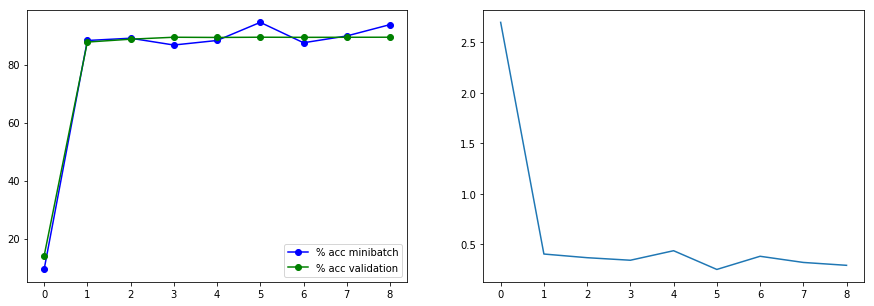

In [128]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(accuracies_minibatch, '-ob')
ax.plot(accuracies_validation, '-og')
ax.legend(['% acc minibatch', '% acc validation'])
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(losses)

#### Try with more layers

- 2 hidden layers
- learning rate decay
- dropout

In [36]:
batch_size = 128
n_hidden_neurons = [1024, 1024]

graph_nn = tf.Graph()

with graph_nn.as_default():
    
    # input
    tf_train_data = tf.placeholder(tf.float32, [batch_size, image_size*image_size])
    tf_train_labels = tf.placeholder(tf.float32, [batch_size, num_labels])
    tf_valid_data = tf.constant(valid_dataset)
    tf_valid_labels = tf.constant(valid_labels)
    tf_test_data = tf.constant(test_dataset)
    tf_test_labels = tf.constant(test_labels)
    
    # model
    weights_l1 = tf.Variable(
        tf.truncated_normal([image_size*image_size, n_hidden_neurons[0]], mean=0.0,
                           stddev=1/image_size)
    )
    biases_l1 = tf.Variable(tf.truncated_normal([n_hidden_neurons[0]], mean=0.0, stddev=1.0))
    
    weights_l2 = tf.Variable(
        tf.truncated_normal(n_hidden_neurons, mean=0.0, stddev=1/math.sqrt(n_hidden_neurons[0]))
    )
    biases_l2 = tf.Variable(tf.truncated_normal([n_hidden_neurons[1]], mean=0.0, stddev=1.0))
    
    weights_l3 = tf.Variable(
        tf.truncated_normal([n_hidden_neurons[1], num_labels], mean=0.0, stddev=1/math.sqrt(n_hidden_neurons[1]))
    )
    biases_l3 = tf.Variable(tf.truncated_normal([num_labels], mean=0.0, stddev=1.0))
    
    keep_prob = 0.75
    output_l1 = tf.nn.relu(tf.matmul(tf_train_data, weights_l1) + biases_l1)
    output_l2 = tf.nn.relu(tf.matmul(tf.nn.dropout(output_l1, keep_prob=keep_prob), weights_l2) + biases_l2)
    output_l3 = tf.matmul(tf.nn.dropout(output_l2, keep_prob=keep_prob), weights_l3) + biases_l3
    
    prediction_mini_batch = tf.nn.softmax(output_l3)
    
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=output_l3,
                                                labels=tf_train_labels))    
    # optimization (SGD)
    # count number of steps taken
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.9, staircase=True)
    sgd = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # calc validation
    output_l1_valid = tf.nn.relu(tf.matmul(tf_valid_data, weights_l1) + biases_l1)
    output_l2_valid = tf.nn.relu(tf.matmul(output_l1_valid, weights_l2) + biases_l2)
    prediction_valid = tf.nn.softmax(tf.matmul(output_l2_valid, weights_l3) + biases_l3)
    
    output_l1_test = tf.nn.relu(tf.matmul(tf_test_data, weights_l1) + biases_l1)
    output_l2_test = tf.nn.relu(tf.matmul(output_l1_test, weights_l2) + biases_l2)
    prediction_test = tf.nn.softmax(tf.matmul(output_l2_test, weights_l3) + biases_l3)
    
num_steps = 10001
batch_size = 128

accuracies_validation = []
accuracies_minibatch = []
losses = []

with tf.Session(graph=graph_nn) as session:
    
    tf.global_variables_initializer().run()
    
    for step in range(num_steps):
        offset = step*batch_size % (train_dataset.shape[0] - batch_size)
        batch_data = train_dataset[offset:offset + batch_size]
        batch_labels = train_labels[offset:offset + batch_size]
        feed_dict = {
            tf_train_data: batch_data,
            tf_train_labels: batch_labels
        }
        _, l, prediction_train = session.run([sgd, loss, prediction_mini_batch], feed_dict=feed_dict)
        
        if step % 1000:
            continue
            
        accuracy_minibatch = accuracy(prediction_train, batch_labels)
        accuracy_validation = accuracy(prediction_valid.eval(), valid_labels)
        losses.append(l)
        accuracies_minibatch.append(accuracy_minibatch)
        accuracies_validation.append(accuracy_validation)
        print('\nStep {}'.format(step))
        print('Learning rate: {:.2f}'.format(learning_rate.eval()))
        print('Loss: {:.2f}'.format(l))
        print('Minibatch accuracy: {:.2f}%'.format(accuracy_minibatch))
        print('Validation accuracy: {:.2f}%'.format(accuracy_validation))
    print('\nTest accuracy: {:.2f}%'.format(accuracy(prediction_test.eval(), test_labels)))


Step 0
Learning rate: 0.50
Loss: 2.85
Minibatch accuracy: 10.94%
Validation accuracy: 10.00%

Step 1000
Learning rate: 0.45
Loss: 0.42
Minibatch accuracy: 87.50%
Validation accuracy: 86.34%

Step 2000
Learning rate: 0.40
Loss: 0.48
Minibatch accuracy: 85.94%
Validation accuracy: 87.56%

Step 3000
Learning rate: 0.36
Loss: 0.43
Minibatch accuracy: 85.16%
Validation accuracy: 88.50%

Step 4000
Learning rate: 0.33
Loss: 0.48
Minibatch accuracy: 85.16%
Validation accuracy: 89.25%

Step 5000
Learning rate: 0.30
Loss: 0.25
Minibatch accuracy: 92.19%
Validation accuracy: 89.79%

Step 6000
Learning rate: 0.27
Loss: 0.32
Minibatch accuracy: 89.84%
Validation accuracy: 90.10%

Step 7000
Learning rate: 0.24
Loss: 0.34
Minibatch accuracy: 89.84%
Validation accuracy: 89.96%

Step 8000
Learning rate: 0.22
Loss: 0.31
Minibatch accuracy: 91.41%
Validation accuracy: 90.20%

Step 9000
Learning rate: 0.19
Loss: 0.37
Minibatch accuracy: 89.06%
Validation accuracy: 90.53%

Step 10000
Learning rate: 0.17
L

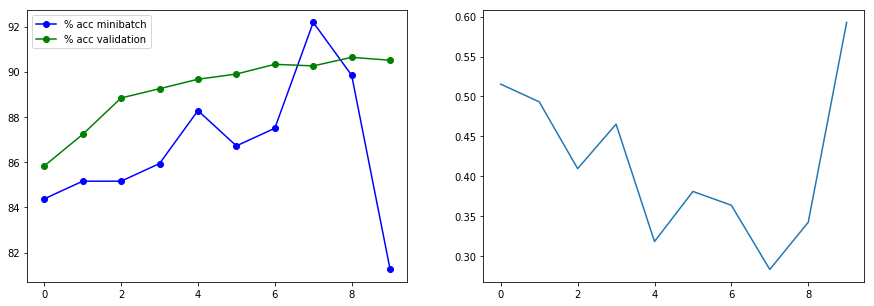

In [35]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(accuracies_minibatch[1:], '-ob')
ax.plot(accuracies_validation[1:], '-og')
ax.legend(['% acc minibatch', '% acc validation'])
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(losses[1:])

### Let's check how the decay varies with different decay rates

In [26]:
import numpy as np

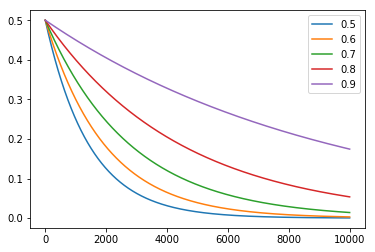

In [40]:
steps = np.arange(10000)
decay_rates = list(np.arange(5, 10)/10)
num_steps = 1000
for decay_rate in decay_rates:
    decayed_learning_rate = 0.5 * decay_rate**(steps / num_steps)
    plt.plot(decayed_learning_rate)
plt.legend(decay_rates)